# LDA: Supervised Data Compression via Linear Discriminant Analysis

### PCA vs LDA

- both can be used as a technique for featue extraction to increase the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models.

- both decomposematrices into eigenvalues and eigenvectors, which will form the new lower-dimensional feature space

- LDA: supervised vs PCA: unsupervised

- LDA: to find the feature subspace that optimizes class separability \
  PCA: to find the orghogonal component axes of maximum variance in a dataset
 
### LDA assumptions

- Data is normally distributed
- Classes have identical covariance matrices
- featuers are statistically independent of each other
 
 
 

## Implementation of LDA

**Step1:** Standardize the d-dimensional dataset (d is the number of features)

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


**Step2:** For each class compute the d-dimensional mean vector

Note: class information is used in this step.

In [4]:
import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis = 0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



**Step3:** Construct the betwen-class scatter matrixn $S_B$ and the within-class scatter matrix $S_W$

In [7]:
# A. Within-classs scatter matrix: scaled by class distribution in training set

d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [8]:
# B. Between-class scatter matrix

mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


**Step4:** Compute the eigenvectors and corresponding eigenvalues of the matrix $S_W^{-1}S_B$

In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Step5:** Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors

In [24]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k:k[0], reverse = True)

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


**Note:** the number of linear discriminants is at most c-1, where c is the number of class labels, since the in-between scatter matrix $S_B$ is the sum of c matrices with rank 1 or less.

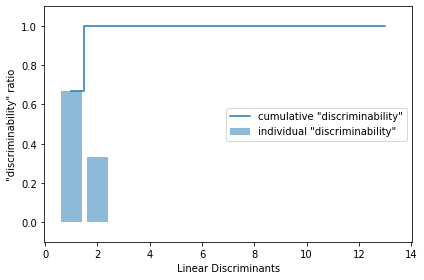

In [25]:
## make a plot to see the discriminability
%matplotlib inline
from matplotlib import pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Step6:** Choose the k eigenvectors that corespond to the k largest eigenvalues to construct a $d*k$-dimensional transformation matrix W; the eigenvectors are the columns of this matrix.

In [28]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


**Step7:** Project the samples onto the new feature subspace using the transformation matrix W.

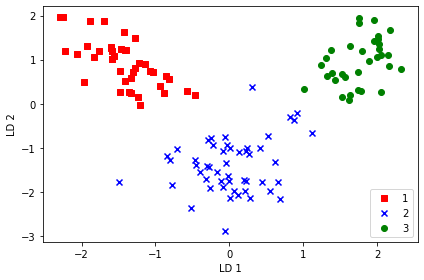

In [31]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## LDA in Sklearn

sklearn.discriminant_analysis.LinearDiscriminantAnalysis(*, solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001)

Parameters:

- solver: {‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
- n_components: Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

In [43]:
# plot decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


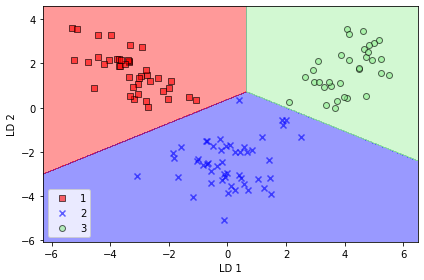

In [44]:
lot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()